In [1]:
import healpy as hp 
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm
import pickle as pl

In [2]:
%load_ext autoreload
%autoreload 2
from taunet.simulation import CMBmap, FGMap, SkySimulation,CMBspectra,MakeSims
from taunet.ncm import NoiseModel

In [3]:
main_dir = '/marconi_work/INF24_litebird/anto/storage/TAUNET2'
paramdir = '/marconi/home/userexternal/aidicher/workspace/taunet/taunet/template_fitting'

In [7]:
method = 'ffp8'
dirname = rf"/marconi_work/INF24_litebird/anto/tmp{'' if method=='roger' else method}"
os.makedirs(dirname,exist_ok=True)
ncm_diag = NoiseModel(True,method=method)
ncm_full = NoiseModel(False,method=method)
nfull, ndiag = [], []
for i in tqdm(range(50)):
    fname =f"{dirname}/nemode_{i}.pkl"
    if not os.path.exists(fname):
        nemode = (hp.alm2cl(ncm_full.Emode(100,i),ncm_full.Emode(143,i)),
                  hp.alm2cl(ncm_diag.Emode(100,i),ncm_diag.Emode(143,i)))
        pl.dump(nemode,open(fname,'wb'))
        nfull.append(nemode[0])
        ndiag.append(nemode[1])
    else:
        nemode = pl.load(open(fname,'rb'))
        nfull.append(nemode[0])
        ndiag.append(nemode[1])
nfull, ndiag = np.array(nfull), np.array(ndiag)

100%|██████████| 50/50 [00:00<00:00, 9397.95it/s]


In [8]:
sky_fullcov = SkySimulation(main_dir,tau=0.06,add_fg=False,noise_diag=False,noise_method='ffp8')
sky_diagcov = SkySimulation(main_dir,tau=0.06,add_fg=False,noise_diag=True,noise_method='ffp8')

tau = 0.06
tau = 0.06


In [9]:
method = 'ffp8'
dirname = rf"/marconi_work/INF24_litebird/anto/tmp{'' if method=='roger' else method}"
os.makedirs(dirname,exist_ok=True)
emode_fullcov, emode_diagcov = [], []
for i in tqdm(range(50)):
    fname =f"{dirname}/emode_{i}.pkl"
    if not os.path.exists(fname):
        emodes = (hp.alm2cl(sky_fullcov.Emode(100,i),sky_fullcov.Emode(143,i)),
                  hp.alm2cl(sky_diagcov.Emode(100,i),sky_diagcov.Emode(143,i)))
        pl.dump(emodes,open(fname,'wb'))
        emode_fullcov.append(emodes[0])
        emode_diagcov.append(emodes[1])
    else:
        emode_fullcov.append(pl.load(open(fname,'rb'))[0])
        emode_diagcov.append(pl.load(open(fname,'rb'))[1])
emode_fullcov, emode_diagcov = np.array(emode_fullcov)/0.54, np.array(emode_diagcov)/0.54

100%|██████████| 50/50 [00:00<00:00, 2927.06it/s]


In [10]:
l = np.arange(len(emode_fullcov[0]))

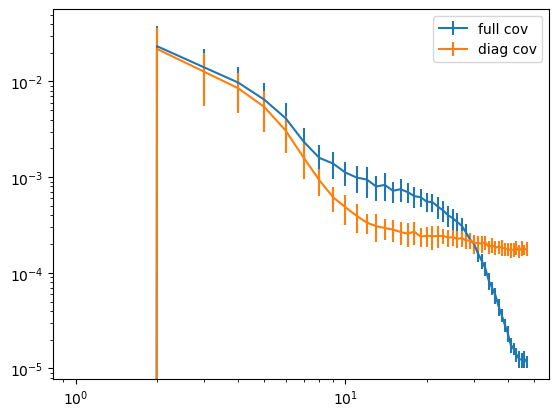

In [11]:
plt.loglog()
plt.errorbar(l,emode_fullcov.mean(axis=0),yerr=emode_fullcov.std(axis=0),label='full cov')
plt.errorbar(l,emode_diagcov.mean(axis=0),yerr=emode_diagcov.std(axis=0),label='diag cov')
plt.legend()

In [13]:
mdiag = MakeSims(main_dir,fg=['s1','d1'],noise_g=False,noise_diag=True,noise_method='ffp8',nsim=30,ssim=20,fullsky=False,)
mfull = MakeSims(main_dir,fg=['s1','d1'],noise_g=False,noise_diag=False,noise_method='ffp8',nsim=30,ssim=20,fullsky=False)

Saved power spectra
tau = 0.06


Generating 353 GHz maps: 100%|██████████| 30/30 [00:00<00:00, 8991.65sim/s]


Generating noise covariance matrices: NoiseModel Diag
Saved power spectra
tau = 0.06


Generating 353 GHz maps: 100%|██████████| 30/30 [00:00<00:00, 58606.95sim/s]

Generating noise covariance matrices: NoiseModel


In [14]:
cl_diag = mdiag.anl_cleaned(50,ret_cmb=False,ret_full=True)
cl_full = mfull.anl_cleaned(50,ret_cmb=False,ret_full=True)

100%|██████████| 50/50 [00:01<00:00, 32.33it/s]


In [15]:
cl_diag /= 0.54
cl_full /= 0.54

In [16]:
ee_theory = sky_diagcov.CMB.EE

/scratch_local/ipykernel_39024/1894781633.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bb_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('ffp8.pdf',dpi=300,bb_inches='tight')


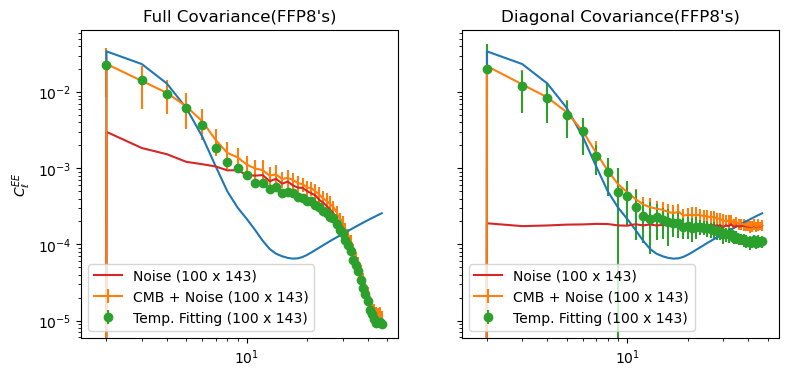

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4),sharey=True)
ax1.loglog(l,ee_theory[l])
ax1.errorbar(l,emode_fullcov.mean(axis=0),yerr=emode_fullcov.std(axis=0),label='CMB + Noise (100 x 143)')
ax1.errorbar(l,cl_full.mean(axis=0)*1e12,yerr=cl_full.std(axis=0)*1e1,fmt='o',label='Temp. Fitting (100 x 143)')
ax1.loglog(l,nfull.mean(axis=0)/0.54,label='Noise (100 x 143)')
ax1.legend(loc='lower left')
ax1.set_xlim(1.5,None)
ax1.set_title("Full Covariance(FFP8's)")
ax1.set_ylabel(r'$C_{\ell}^{EE}$')

ax2.loglog(l,ee_theory[l])
ax2.errorbar(l,emode_diagcov.mean(axis=0),yerr=emode_diagcov.std(axis=0),label='CMB + Noise (100 x 143)')
ax2.errorbar(l,cl_diag.mean(axis=0)*1e12,yerr=cl_diag.std(axis=0)*1e12,fmt='o',label='Temp. Fitting (100 x 143)')
ax2.loglog(l,ndiag.mean(axis=0)/0.54,label='Noise (100 x 143)')
ax2.legend(loc='lower left')
ax2.set_xlim(1.5,None)
ax2.set_title("Diagonal Covariance(FFP8's)")
plt.savefig('ffp8.pdf',dpi=300,bb_inches='tight')


In [7]:
m = MakeSims(main_dir,fg=['s1','d1'],noise_g=False,noise_diag=True,nsim=50,ssim=0,fullsky=False,noise_method='roger')

Saved power spectra


In [15]:
band = 143
m.make_params(band,paramdir)
m.job_file(band, paramdir)

In [16]:
m.submit_job(band,paramdir)

Submitted batch job 13036306


In [1]:
m.plot_cleaned(50)
#plt.loglog(hp.alm2cl(e100,e143),label='CMB')

NameError: name 'm' is not defined

In [4]:
#s0d0_fs = MakeSims(main_dir,fg=['s0','d0'],noise_g=True,nsim=50,ssim=0,fullsky=True)
s0d0 = MakeSims(main_dir,fg=['s0','d0'],noise_g=True,nsim=50,ssim=0,fullsky=False)
#s1d1 = MakeSims(main_dir,fg=['s1','d1'],noise_g=True,nsim=50,ssim=0,fullsky=False)
s1d1_roger = MakeSims(main_dir,fg=['s1','d1'],noise_g=False,nsim=50,ssim=0,fullsky=False)

Saved power spectra
tau = 0.06


Generating 353 GHz maps: 100%|██████████| 50/50 [00:00<00:00, 3695.03sim/s]


Generating noise covariance matrices: NoiseModelGaussian
Saved power spectra
tau = 0.06


Generating 353 GHz maps: 100%|██████████| 50/50 [00:00<00:00, 27924.79sim/s]

Generating noise covariance matrices: NoiseModel


In [5]:
#cmbnoise_fs = SkySimulation(main_dir,0.06,fg=['s0','d0'],noise_g=True,fullsky=True,add_fg=False,add_noise=False,nsim=50)
cmbnoise_ps = SkySimulation(main_dir,0.06,fg=['s0','d0'],noise_g=True,fullsky=False,add_fg=False,add_noise=False,nsim=50)

tau = 0.06


In [6]:
#cmbnoise_cl_fs = []
cmbnoise_cl_ps = []
for i in tqdm(range(100),desc='CMB noise',unit='sim'):
   # emode_fs = cmbnoise_fs.Emode(100,i)
    emode_ps = cmbnoise_ps.Emode(100,i)
   # cmbnoise_cl_fs.append(hp.alm2cl(emode_fs))
    cmbnoise_cl_ps.append(hp.alm2cl(emode_ps))
#cmbnoise_cl_fs = np.array(cmbnoise_cl_fs)
cmbnoise_cl_ps = np.array(cmbnoise_cl_ps)

CMB noise:   0%|          | 0/100 [00:00<?, ?sim/s]

CMB noise: 100%|██████████| 100/100 [01:39<00:00,  1.01sim/s]


In [7]:
#ee_t,ee_s0d0_fs = s0d0_fs.anl_cleaned(50,True)
ee_s0d0 = s0d0.anl_cleaned(50,True,ret_cmb=False)
#ee_t,ee_s1d1 = s1d1.anl_cleaned(50,True)
ee_s1d1_roger = s1d1_roger.anl_cleaned(50,True,ret_cmb=False)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


In [8]:
l = np.arange(len(ee_s0d0[0]))

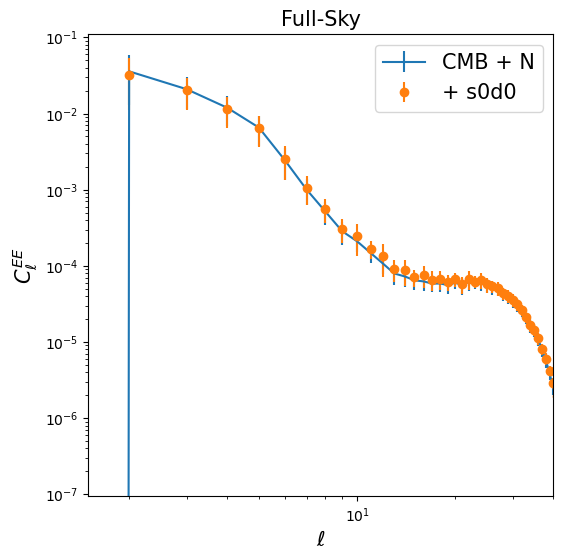

In [16]:
plt.figure(figsize=(6,6))
plt.errorbar(l,cmbnoise_cl_fs.mean(axis=0) ,yerr=cmbnoise_cl_fs.std(axis=0),label='CMB + N')
plt.errorbar(l,ee_s0d0_fs.mean(axis=0),yerr=ee_s0d0_fs.std(axis=0),fmt='o',label='+ s0d0')
plt.loglog()
plt.title('Full-Sky', fontsize=15)
plt.legend(fontsize=15)
plt.xlim(1.5,40)
plt.xlabel('$\ell$', fontsize=15)
plt.ylabel('$C_\ell^{EE}$', fontsize=15)
plt.savefig('fullsky.pdf',dpi=300,bbox_inches='tight')

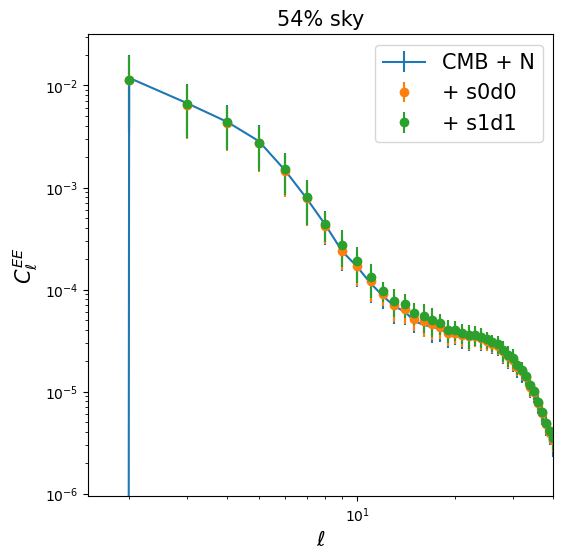

In [17]:
plt.figure(figsize=(6,6))
plt.errorbar(l,cmbnoise_cl_ps.mean(axis=0) ,yerr=cmbnoise_cl_ps.std(axis=0),label='CMB + N')
plt.errorbar(l,ee_s0d0.mean(axis=0),yerr=ee_s0d0.std(axis=0),fmt='o',label='+ s0d0')
plt.errorbar(l,ee_s1d1.mean(axis=0),yerr=ee_s1d1.std(axis=0),fmt='o',label='+ s1d1')
plt.loglog()
plt.title('54% sky', fontsize=15)
plt.legend(fontsize=15)
plt.xlim(1.5,40)
plt.xlabel('$\ell$', fontsize=15)
plt.ylabel('$C_\ell^{EE}$', fontsize=15)
plt.savefig('54sky.pdf',dpi=300,bbox_inches='tight')

Text(0, 0.5, '$C_\\ell^{EE}$')

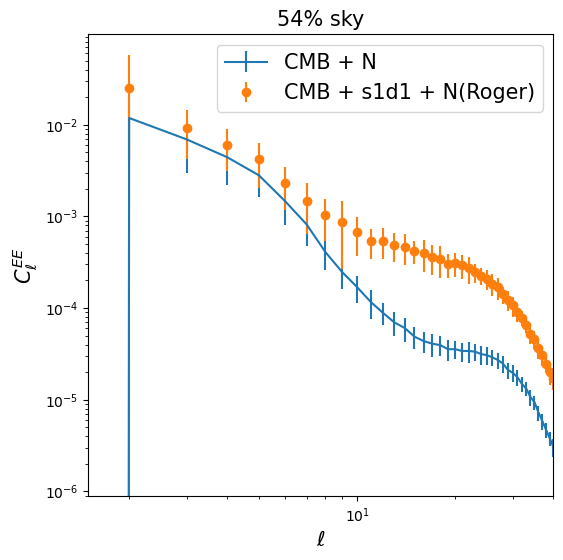

In [10]:
plt.figure(figsize=(6,6))
plt.errorbar(l,cmbnoise_cl_ps.mean(axis=0) ,yerr=cmbnoise_cl_ps.std(axis=0),label='CMB + N')
#plt.errorbar(l,ee_s1d1.mean(axis=0),yerr=ee_s1d1.std(axis=0),fmt='o',label='+ s1d1')
plt.errorbar(l,ee_s1d1_roger.mean(axis=0)*1e12,yerr=ee_s1d1_roger.std(axis=0)*1e12,fmt='o',label='CMB + s1d1 + N(Roger)')
plt.loglog()
plt.title('54% sky', fontsize=15)
plt.legend(fontsize=15)
plt.xlim(1.5,40)
plt.xlabel('$\ell$', fontsize=15)
plt.ylabel('$C_\ell^{EE}$', fontsize=15)
#plt.savefig('54skyR.pdf',dpi=300,bbox_inches='tight')
